In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from textblob import TextBlob
import re
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Data Collection

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [3]:
size = df.shape
print("Column names:", df.columns)
print(size)

Column names: Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')
(732, 15)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB


In [5]:
df.describe()

,Unnamed: 0.1,Unnamed: 0,Retweets,Likes,Year,Month,Day,Hour
count,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000
mean,366.464481,369.740437,21.508197,42.901639,2020.471311,6.122951,15.497268,15.521858
std,211.513936,212.428936,7.061286,14.089848,2.802285,3.411763,8.474553,4.113414
min,0.000000,0.000000,5.000000,10.000000,2010.000000,1.000000,1.000000,0.000000
25%,183.750000,185.750000,17.750000,34.750000,2019.000000,3.000000,9.000000,13.000000
50%,366.500000,370.500000,22.000000,43.000000,2021.000000,6.000000,15.000000,16.000000
75%,549.250000,553.250000,25.000000,50.000000,2023.000000,9.000000,22.000000,19.000000
max,732.000000,736.000000,40.000000,80.000000,2023.000000,12.000000,31.000000,23.000000


In [6]:
remove = ['Sentiment', 'Month', 'Day', 'Hour']
for col in remove:
    if col in df.columns:
        df = df.drop(col, axis=1)
    else:
        print(f"Column '{col}' not found in the DataFrame.")

In [7]:
df.isnull().sum()

Unnamed: 0.1    0
Unnamed: 0      0
Text            0
Timestamp       0
User            0
Platform        0
Hashtags        0
Retweets        0
Likes           0
Country         0
Year            0
dtype: int64

In [8]:
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
727    False
728    False
729    False
730    False
731    False
Length: 732, dtype: bool

# Data Pre-processing

In [9]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['date'] = df['Timestamp'].dt.strftime('%Y-%m-%d')
df['day'] = df['Timestamp'].dt.strftime('%A')
df.to_csv('data.csv', index=False)

In [10]:
df = df.drop('Timestamp', axis=1)
df.to_csv('data.csv', index=False)

In [11]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,User,Platform,Hashtags,Retweets,Likes,Country,Year,date,day
0,0,0,Enjoying a beautiful day at the park! ...,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,2023-01-15,Sunday
1,1,1,Traffic was terrible this morning. ...,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,2023-01-15,Sunday
2,2,2,Just finished an amazing workout! 💪 ...,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,2023-01-15,Sunday
3,3,3,Excited about the upcoming weekend getaway! ...,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,2023-01-15,Sunday
4,4,4,Trying out a new recipe for dinner tonight. ...,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,2023-01-15,Sunday


In [12]:
print(df['Text'])

0       Enjoying a beautiful day at the park!        ...
1       Traffic was terrible this morning.           ...
2       Just finished an amazing workout! 💪          ...
3       Excited about the upcoming weekend getaway!  ...
4       Trying out a new recipe for dinner tonight.  ...
                             ...                        
727    Collaborating on a science project that receiv...
728    Attending a surprise birthday party organized ...
729    Successfully fundraising for a school charity ...
730    Participating in a multicultural festival, cel...
731    Organizing a virtual talent show during challe...
Name: Text, Length: 732, dtype: object


In [13]:
def text_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [14]:
df['Cleaned_Text'] = df['Text'].apply(text_processing)
print(df['Cleaned_Text'])

0                            enjoying beautiful day park
1                               traffic terrible morning
2                               finished amazing workout
3                       excited upcoming weekend getaway
4                       trying new recipe dinner tonight
                             ...                        
727    collaborating science project received recogni...
728    attending surprise birthday party organized fr...
729    successfully fundraising school charity initia...
730    participating multicultural festival celebrati...
731    organizing virtual talent show challenging tim...
Name: Cleaned_Text, Length: 732, dtype: object


In [15]:
df.to_csv('data.csv',index=False)
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,User,Platform,Hashtags,Retweets,Likes,Country,Year,date,day,Cleaned_Text
0,0,0,Enjoying a beautiful day at the park! ...,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,2023-01-15,Sunday,enjoying beautiful day park
1,1,1,Traffic was terrible this morning. ...,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,2023-01-15,Sunday,traffic terrible morning
2,2,2,Just finished an amazing workout! 💪 ...,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,2023-01-15,Sunday,finished amazing workout
3,3,3,Excited about the upcoming weekend getaway! ...,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,2023-01-15,Sunday,excited upcoming weekend getaway
4,4,4,Trying out a new recipe for dinner tonight. ...,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,2023-01-15,Sunday,trying new recipe dinner tonight


In [16]:
df['Cleaned_Text'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 732 entries, 0 to 731
Series name: Cleaned_Text
Non-Null Count  Dtype 
--------------  ----- 
732 non-null    object
dtypes: object(1)
memory usage: 5.8+ KB


In [17]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [18]:
df['Polarity'] = df['Cleaned_Text'].apply(polarity)

In [19]:
df.to_csv('data.csv',index=False)
print(df[['Cleaned_Text', 'Polarity']])

                                          Cleaned_Text  Polarity
0                          enjoying beautiful day park  0.675000
1                             traffic terrible morning -1.000000
2                             finished amazing workout  0.600000
3                     excited upcoming weekend getaway  0.375000
4                     trying new recipe dinner tonight  0.136364
..                                                 ...       ...
727  collaborating science project received recogni...  0.700000
728  attending surprise birthday party organized fr...  0.600000
729  successfully fundraising school charity initia...  0.516667
730  participating multicultural festival celebrati...  1.000000
731  organizing virtual talent show challenging tim...  0.500000

[732 rows x 2 columns]


In [20]:
def sentiment(n):
    if n<0:
        return "Negative"
    elif n==0:
        return "Neutral"
    elif n>0:
        return "Positive"

In [21]:
df['Sentiment'] = df['Polarity'].apply(sentiment)

In [22]:
df.to_csv('data.csv',index=False)
print(df[['Polarity','Sentiment']])

     Polarity Sentiment
0    0.675000  Positive
1   -1.000000  Negative
2    0.600000  Positive
3    0.375000  Positive
4    0.136364  Positive
..        ...       ...
727  0.700000  Positive
728  0.600000  Positive
729  0.516667  Positive
730  1.000000  Positive
731  0.500000  Positive

[732 rows x 2 columns]


In [23]:
for text in df.nlargest(10, 'Polarity')['Text']:
    print(text)

 Laughter is the best medicine—enjoying a comedy show. 
 Experiencing awe at the breathtaking sunset.            
Awe-struck by the breathtaking sunrise over the mountains.      
At the summit of Machu Picchu, a breathtaking panorama that whispers the secrets of ancient civilizations. 
At the summit of Mount Fuji, a breathtaking sunrise that paints the sky with hues of accomplishment. 
Trying to master the perfect kickflip on my skateboard. Skating into the weekend like a pro! 
Embarking on a mission to find the best burger joint in town. Burger connoisseur: Reporting for duty! 
Participating in a multicultural festival, celebrating diversity with music, dance, and delicious food! 
 Embracing imperfections, finding acceptance in the mosaic of life's beautiful chaos. 
Creating a beautiful mural with fellow art enthusiasts. The power of collaboration and creativity! 


In [24]:
for text in df.nsmallest(10, 'Polarity')['Text']:
    print(text)

 Traffic was terrible this morning.                 
 The state of the world's environment is just disgusting. 
 The state of corruption in our society is utterly disgusting. 
 Fearful eyes scanning the shadows, a prisoner of the night, terrorized by the lurking monsters born from the mind's darkest corners. 
 Grief overwhelms, a storm of emotions within.      
Torn apart by grief, the echoes of loss reverberate through the soul. 
In the symphony of grief, each tear is a note, composing a melancholic melody. 
 Fuming with anger after a heated argument.            
 Frustrated fingers tapping on the keyboard, a symphony of annoyance composing an unsolvable puzzle of unmet expectations. 
 Envious eyes fixated on the gilded prize, a heartache fueled by the painful desire for possessions that seem forever out of reach. 


# Data Visualization

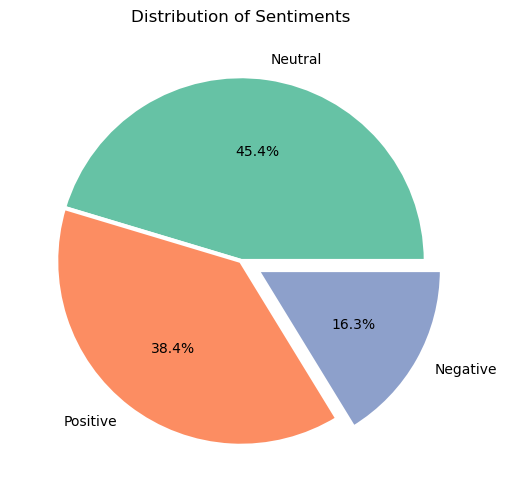

In [25]:
sentiments = df['Sentiment'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(sentiments, labels=sentiments.index, autopct='%1.1f%%',
        colors=sns.color_palette('Set2'), explode=[0, 0, 0.1],wedgeprops={'linewidth': 3, 'edgecolor': 'white'})
plt.title('Distribution of Sentiments')
plt.show()

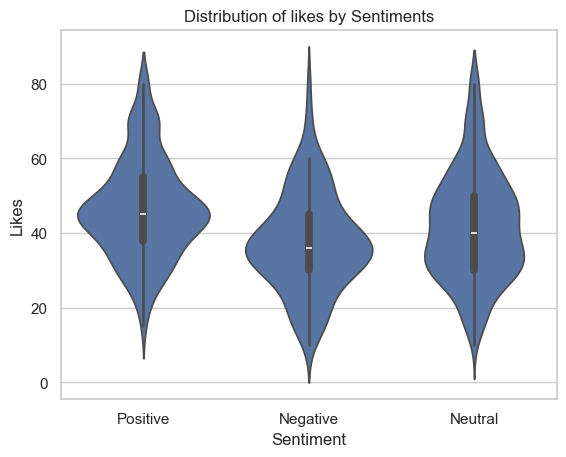

In [26]:
sns.set(style='whitegrid')
sns.violinplot(x="Sentiment", y="Likes", data=df)
plt.title('Distribution of likes by Sentiments')
plt.show()

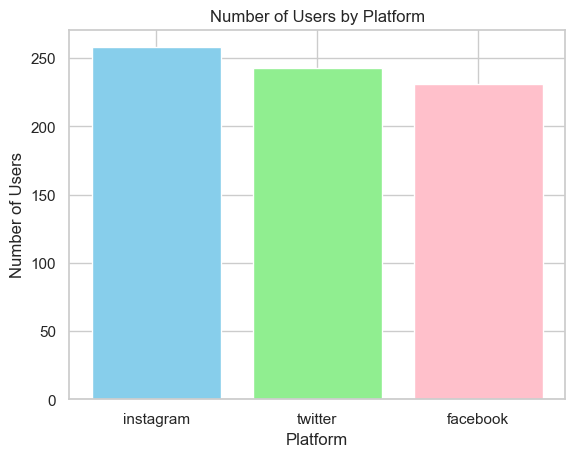

In [27]:
df['Platform'] = df['Platform'].str.strip().str.lower()
counts = df['Platform'].value_counts()
plt.bar(counts.index, counts.values, color=['skyblue', 'lightgreen','pink'])
plt.title('Number of Users by Platform')
plt.xlabel('Platform')
plt.ylabel('Number of Users')
plt.show()

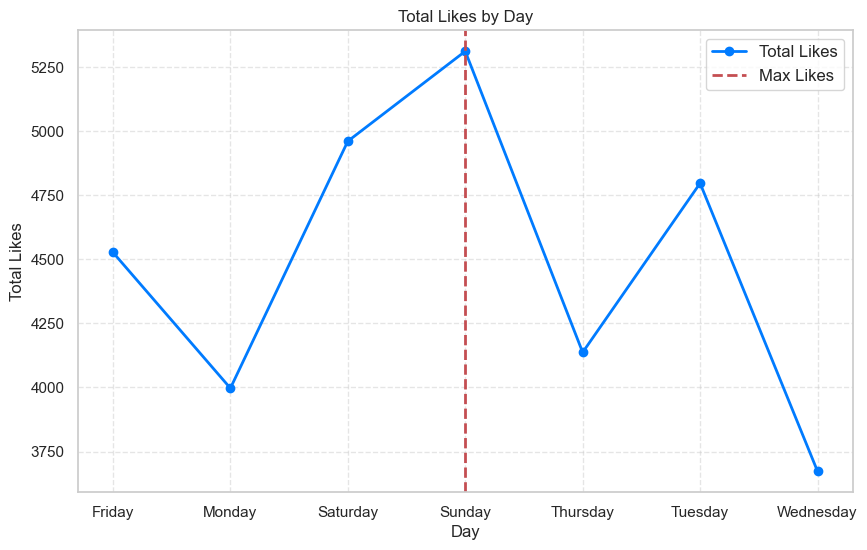

In [28]:
likes_by_day = df.groupby('day')['Likes'].sum()
plt.figure(figsize=(10, 6))
plt.plot(likes_by_day.index, likes_by_day.values, marker='o', linestyle='-', color='#007bff', linewidth=2, label='Total Likes')
plt.xlabel('Day')
plt.ylabel('Total Likes')
plt.title('Total Likes by Day')
plt.grid(True, linestyle='--', alpha=0.5)
max_likes_day = likes_by_day.idxmax()
plt.axvline(x=max_likes_day, color='r', linestyle='--', linewidth=2, label='Max Likes')
plt.legend(loc='upper right', fontsize=12)
plt.show()

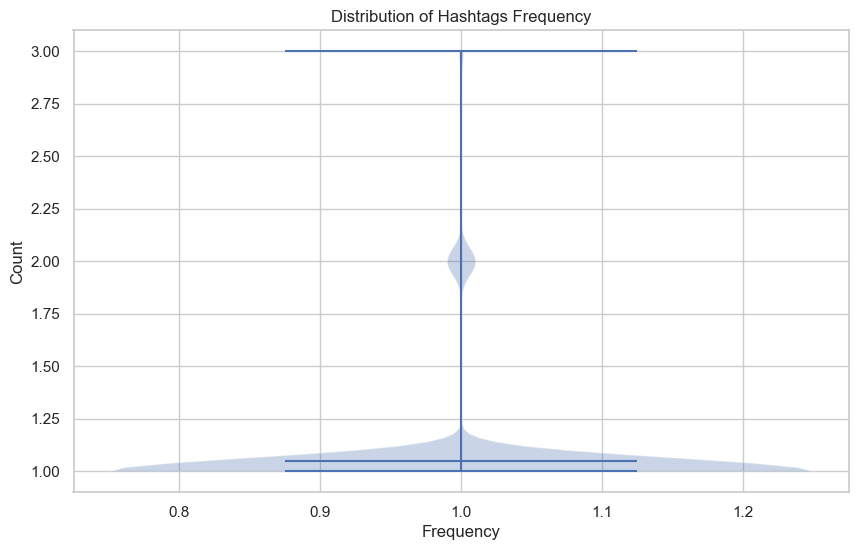

In [29]:
h_counts = df['Hashtags'].value_counts()
plt.figure(figsize=(10, 6))
plt.violinplot(h_counts.values, showmeans=True)
plt.title('Distribution of Hashtags Frequency')
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.show()

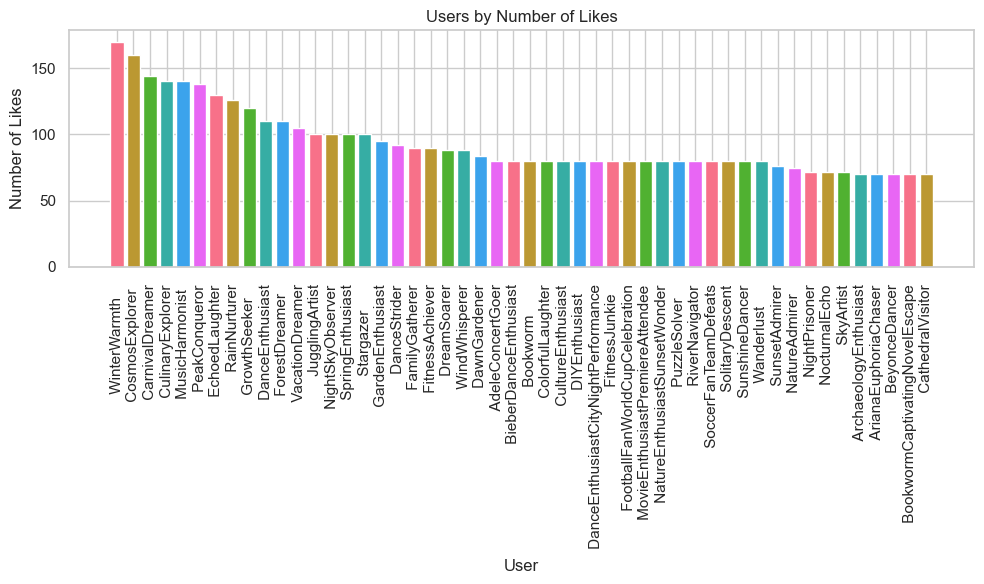

In [30]:
likes_by_user = df.groupby('User')['Likes'].sum().nlargest(50)
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.bar(likes_by_user.index, likes_by_user.values, color=sns.color_palette())
plt.xlabel('User')
plt.ylabel('Number of Likes')
plt.title('Users by Number of Likes')
plt.xticks(range(len(likes_by_user)), likes_by_user.index, rotation=90)  
plt.tight_layout() 
plt.show()

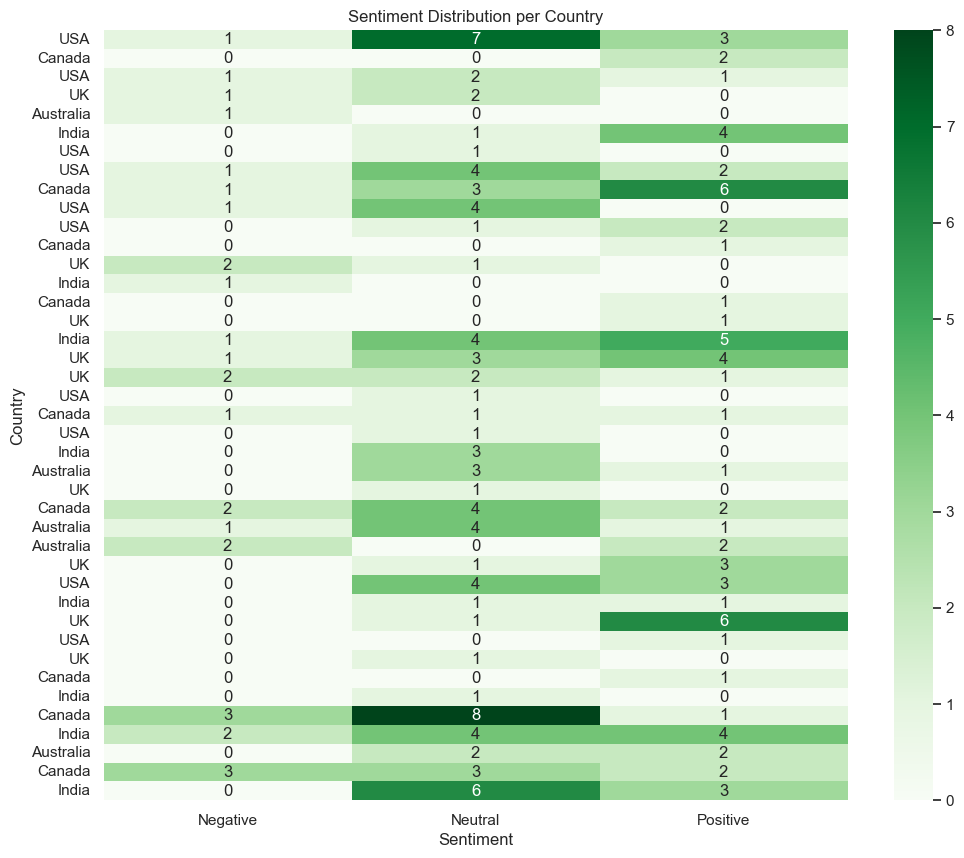

In [31]:
ct = pd.crosstab(df.head(180)['Country'], df.head(180)['Sentiment'])
plt.figure(figsize=(12, 10))  
g = sns.heatmap(ct, annot=True, cmap='Greens', fmt='d') 
plt.xlabel('Sentiment')
plt.ylabel('Country')
plt.title('Sentiment Distribution per Country')
c_names = df.head(180)['Country'].unique().tolist()
c_names = [name.strip() for name in c_names]
g.set_yticklabels(c_names)  
plt.show()

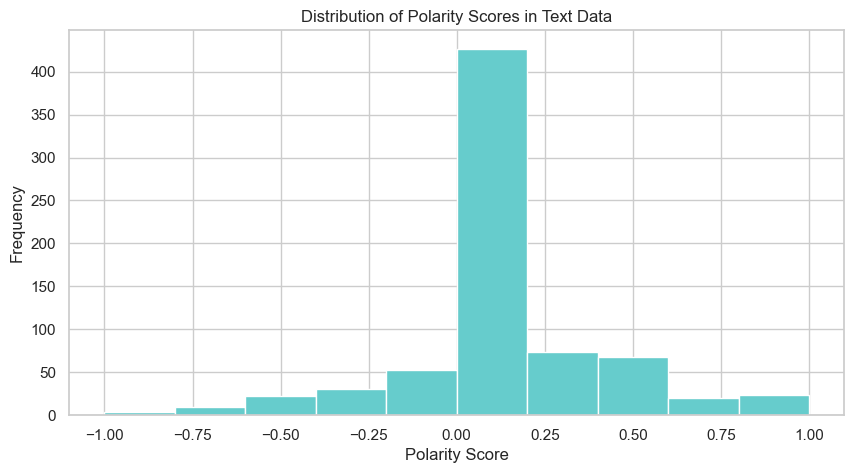

In [32]:
df["Polarity"].plot(kind="hist",color="#66CCCC",figsize=(10, 5))
plt.title("Distribution of Polarity Scores in Text Data")
plt.xlabel("Polarity Score")
plt.ylabel("Frequency")
plt.show()

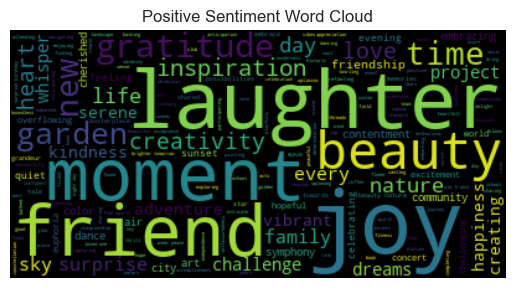

In [33]:
sia = SentimentIntensityAnalyzer()
sentiments = df['Cleaned_Text'].apply(lambda x: sia.polarity_scores(x))
positive_words = df['Cleaned_Text'][sentiments.apply(lambda x: x['compound'] >=0.5)]
wordcloud = WordCloud(max_font_size=70, background_color="black").generate(' '.join(positive_words))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Sentiment Word Cloud")
plt.show()

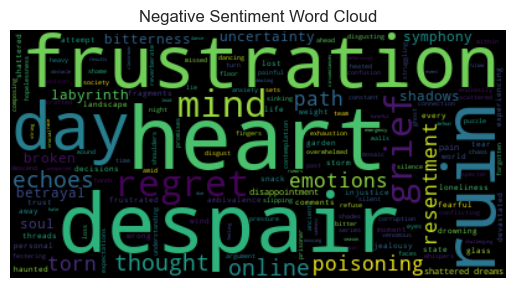

In [34]:
sia = SentimentIntensityAnalyzer()
sentiments = df['Cleaned_Text'].apply(lambda x: sia.polarity_scores(x))
negative_words = df['Cleaned_Text'][sentiments.apply(lambda x: x['compound'] <=-0.5)]
wordcloud = WordCloud(max_font_size=70, background_color="black").generate(' '.join(negative_words))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Sentiment Word Cloud")
plt.show()